# Semantic segmentation of medical images
## Subgoal: implement and test varoious models




---


1. Download the dataset: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>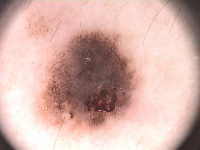</td><td>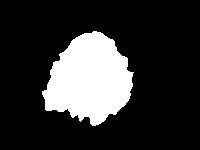</td></tr></table>

2. Unarchive the data.


These are pictures of two types of **skin lesions:** melanoma and moles.
In this project we will not classify them, but we will **segment** them.

In [1]:
!wget -c https://www.dropbox.com/s/r4umod6gtfhs72b/PH2Dataset.rar

--2023-04-25 19:42:09--  https://www.dropbox.com/s/r4umod6gtfhs72b/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/r4umod6gtfhs72b/PH2Dataset.rar [following]
--2023-04-25 19:42:10--  https://www.dropbox.com/s/raw/r4umod6gtfhs72b/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1feedae6960aea1f093e1311e3.dl.dropboxusercontent.com/cd/0/inline/B62WD0uBNIWgR5TXBGfUMyZB8s8_vM5uJVeswisetZqs5jpjV8UbAdtHgzSriHd3b_km93g8B1guPsVDvG2G4T1a42NapOD01HBHp8iVttd08xmMS_rasjud4WqdWiektu7LW1uC-FTC6cHVlBqbjU9tfs6MiJWqZq1a8jcdl2RkzQ/file# [following]
--2023-04-25 19:42:10--  https://uc1feedae6960aea1f093e1311e3.dl.dropboxusercontent.com/cd/0/inline/B62WD0uBNIWgR5TXBGfUMyZB8s8_vM5uJVeswisetZqs5jpjV8UbAdtHgzSriHd3b_km93g

In [2]:
!ls

PH2Dataset.rar	sample_data


In [3]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

The structure of the dataset is below:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Here `X.bmp` is the image to be segmented, `X_lesion.bmp` is the result of the segmentation.

To download we use skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [1]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'


for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Images have different sizes. Let's resize them to $256\times256 $ pixels. 
The used function will also automatically normalize images in the range $[0,1]$.


In [2]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [3]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [5]:
len(lesions)

200

Let's check correctness:

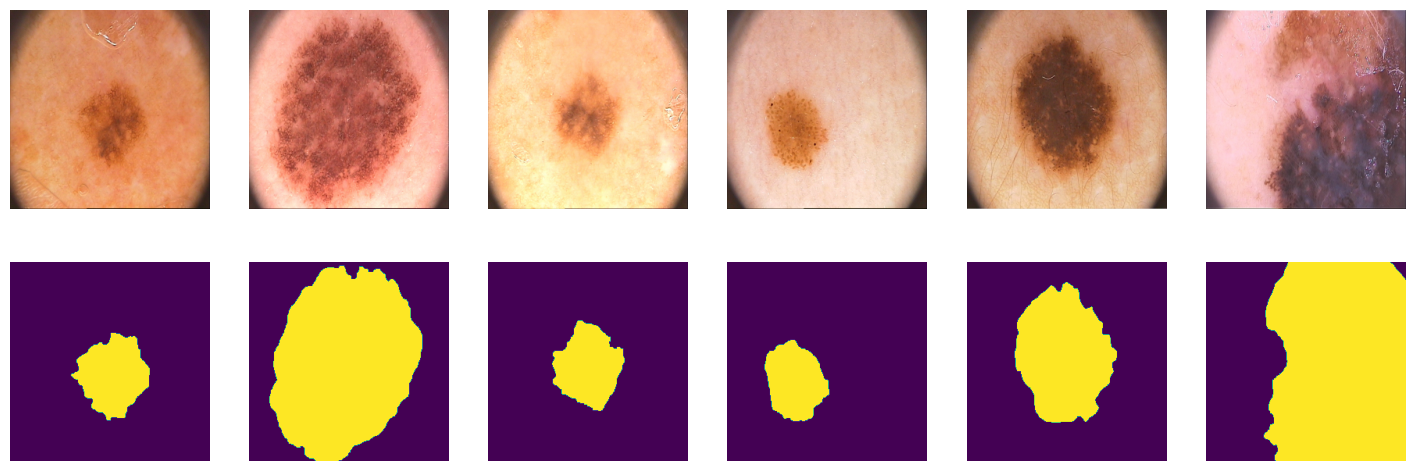

In [4]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

We'll divide our 200 images into 100/50/50s
 for training, validation and test respectively

In [5]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [8]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [6]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [7]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Implementation of different architectures:
Our goal is to implement several neural network architectures to solve the semantic segmentation problem. Compare them in terms of quality on a test and try different loss functions for them.

-----------------------------------------------------------------------------------------

# SegNet

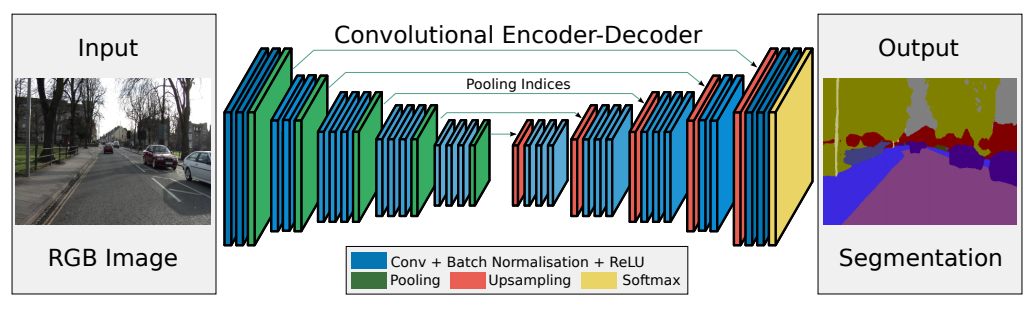

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [9]:
from torchvision import datasets, models, transforms

# Посмотрим, как устроена VGG16 с BatchNorm
models.vgg16_bn()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [11]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
          nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(64),
          nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(kernel_size = 2, stride = 2) # 256 -> 128
        self.enc_conv1 = nn.Sequential(
          nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(128),
          nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
          nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(256),
          nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
          nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(512),
          nn.ReLU(),
          nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(512),
          nn.ReLU(),
          nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(512),
          nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn. Sequential(
          nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=1),                      
          nn.BatchNorm2d(1024),
          nn.ReLU(inplace=True),
          nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1),
          nn.BatchNorm2d(512),
          nn.ReLU(inplace=True)
        )

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
          nn.Conv2d(in_channels = 512, out_channels = 256, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(256),
          nn.ReLU()
        )
        self.upsample1 = nn.Upsample(scale_factor=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
          nn.Conv2d(in_channels = 256, out_channels = 128, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(128),
          nn.ReLU()
        )
        self.upsample2 = nn.Upsample(scale_factor=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
          nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(64),
          nn.ReLU()
        )
        self.upsample3 = nn.Upsample(scale_factor=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
          nn.Conv2d(in_channels = 64, out_channels = 1, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(1),
          nn.ReLU(),
          nn.Conv2d(in_channels = 1, out_channels = 1, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(1),
          #nn.ReLU()
                                                                                             
        )

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b))
        d1 = self.dec_conv1(self.upsample1(d0))
        d2 = self.dec_conv2(self.upsample2(d1))
        d3 = self.dec_conv3(self.upsample3(d2)) # no activation
        return d3

## Metric.

This section proposes to use the following metric to evaluate quality:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

The intersection (A ∩ B) consists of pixels found in both the prediction mask and the underlying truth mask, whereas the union (A ∪ B) simply consists of all pixels found in either the prediction mask or the target mask.

For an example, let's look at truth (left) and prediction (right):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Then the intersection and union will look like this:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [9]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## Loss function.

Just as important as building an architecture is defining the **optimizer** and the **loss function.**

The loss function is what we are trying to minimize. Many of these can be used for the binary semantic segmentation task. 

A popular method for binary segmentation is *binary cross-entropy*, which is defined as follows:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

where $y$ is the target of the desired outcome and $\hat y$ is the output of the model. $\sigma$ is a [*logistic* function](https://en.wikipedia.org/wiki/Sigmoid_function) that converts a real number $\mathbb R$ into a probability $[0,1]$.

However, this loss suffers from numerical instability problems. Most importantly, $\lim_{x\rightarrow0}\log(x)=\infty$ leads to instability in the optimization process. It is recommended to look at the following [simplification](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). This function is equivalent to the first one and is not as prone to numerical instability:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [10]:
def bce_loss(y_real, y_pred):
    loss = y_pred - y_real*y_pred + (1 + torch.exp(-y_pred)).log()
    return loss.mean()

## Training

Here's the training cycle for the model

In [11]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    torch.cuda.empty_cache()
    tr_loss = []
    val_loss = []

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device) 

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch,Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)

        toc = time()
        print('loss: %f' % avg_loss)
        tr_loss.append(avg_loss)

        # show intermediate results
        avg_loss_val = 0
        model.eval()  # testing mode
        for X_valid, Y_valid in data_val:
            with torch.no_grad():
                Y_hat = model(X_valid.to(device)).detach().cpu()# detach and put into cpu
                loss = loss_fn(Y_valid, Y_hat) # forward-pass
                avg_loss_val += loss / len(data_val)

        toc = time()
        print('val_loss: %f' % avg_loss_val)
        val_loss.append(avg_loss_val)

        #Y_hat = model(X_val.to(device)).detach().cpu() # detach and put into cpu

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')

            plt.subplot(3, 6, k+13)
            plt.imshow(Y_val[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

    return(tr_loss, val_loss)

## Inference

Once the model is trained, this feature can be used to predict segmentation on new data:

In [12]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [13]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
      with torch.no_grad():
        Y_pred = model(X_batch.to(device))
        Y_pred = torch.ones_like(Y_pred) * (Y_pred > 0.5)
        scores += metric(Y_pred, Y_label.to(device)).mean().item()
        
    return scores/len(data)

## Main point: training



In [22]:
model = SegNet().to(device)

In [14]:
import gc

def clear_gpu_memory():
    torch.cuda.empty_cache()
    variables = gc.collect()
    del variables

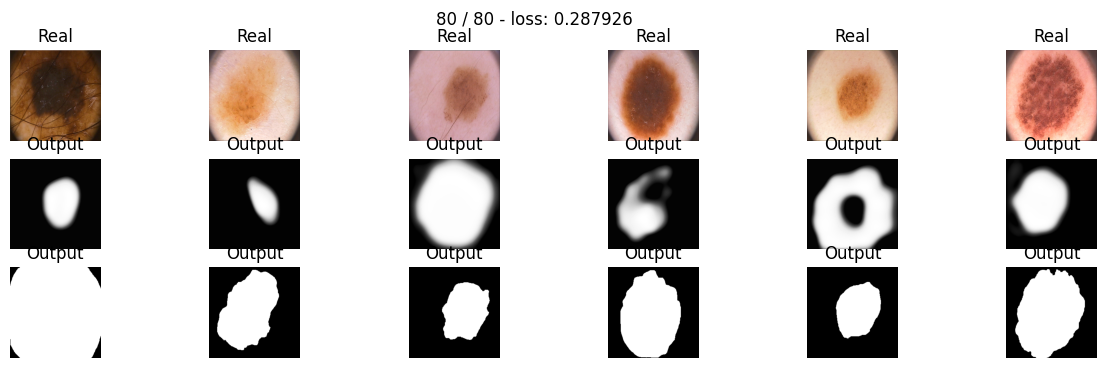

In [24]:
max_epochs = 80
optim = torch.optim.AdamW(model.parameters(), lr=0.001)
results_seg_bce = train(model, optim, bce_loss, max_epochs, data_tr, data_val)

In [25]:
score_seg_bce = score_model(model, iou_pytorch, data_val)

In [26]:
score_seg_bce

0.6580000221729279

In [15]:
def loss_dynamics(results):
    tr_l = [results[0][i].cpu().item() for i in range(len(results[0]))]
    val_l = [results[1][i].cpu().item() for i in range(len(results[1]))]

    plt.figure(figsize=(15, 9))
    plt.plot(tr_l, label="train_loss")
    plt.plot(val_l, label="val_loss")

    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

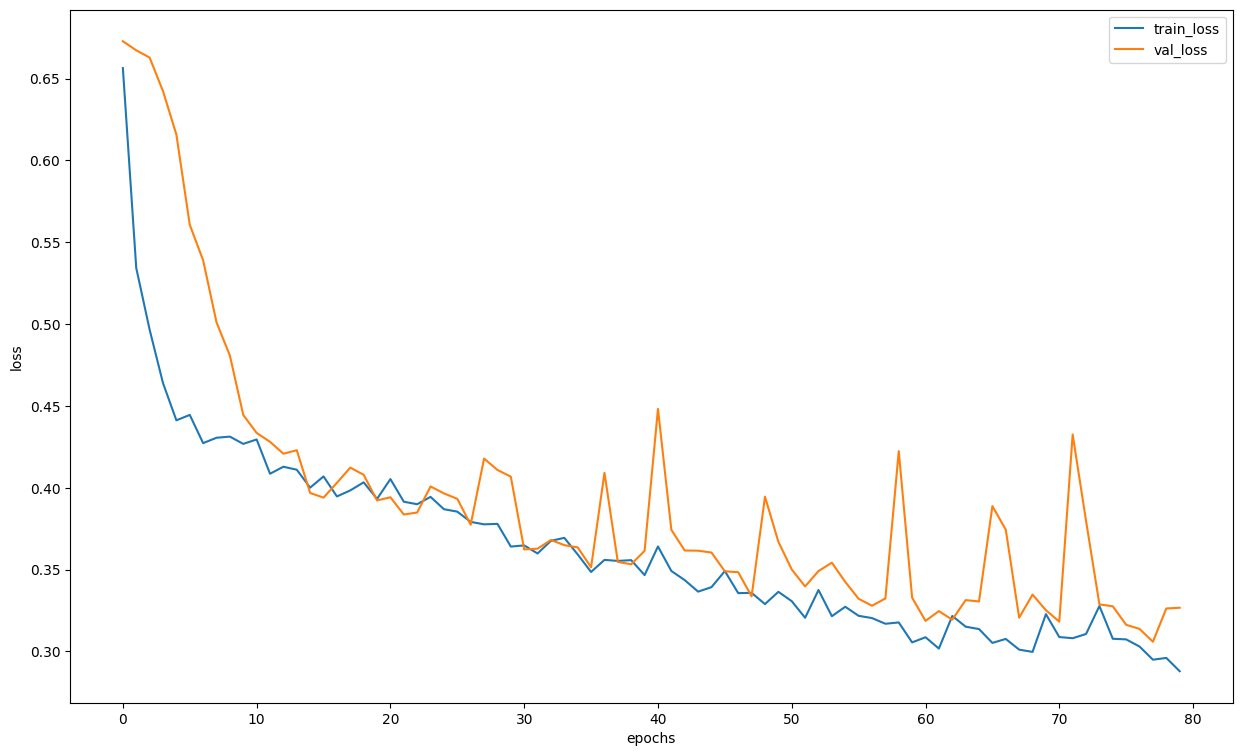

In [28]:
loss_dynamics(results_seg_bce)

The training sample is very small, so the probability of overfitting is very high. After trying different numbers of epochs, I notices that somewhere after 100 the gap between the losses increases and the validation loss reaches a plateau. Therefore, in my opinion, training around 80-100 epochs is optimal.

-----------------------------------------------------------------------------------------

## Additional loss functions 

**1. Dice coefficient:** Given two masks $X$ and $Y$, the general metric for measuring the distance between these two masks is given as follows:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

This function is not differentiable, but it is a necessary property for gradient descent. In this case, we can approximate it using:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$




In [29]:
def dice_loss(y_real, y_pred):
    smooth = 1e-8
    outputs = y_pred.sigmoid().squeeze(1)  
    labels = y_real.squeeze(1)    

    num = (outputs * labels).sum()
    denom = (outputs + labels).sum()
    r = 1 - ((2. * num + smooth) / (denom + smooth)) #/(256*256)
    
    return r 

In [36]:
clear_gpu_memory()

Let's test:

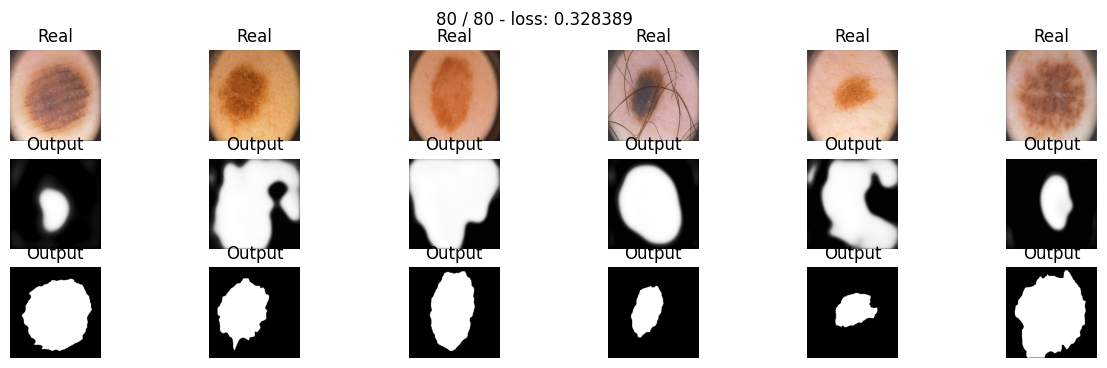

In [31]:
model_dice = SegNet().to(device)

max_epochs = 80
optim = torch.optim.AdamW(model_dice.parameters(), lr=0.001)
result_seg_dice = train(model_dice, optim, dice_loss, max_epochs, data_tr, data_val)

In [32]:
score_seg_dice = score_model(model_dice, iou_pytorch, data_val)

In [33]:
score_seg_dice

0.6759999990463257

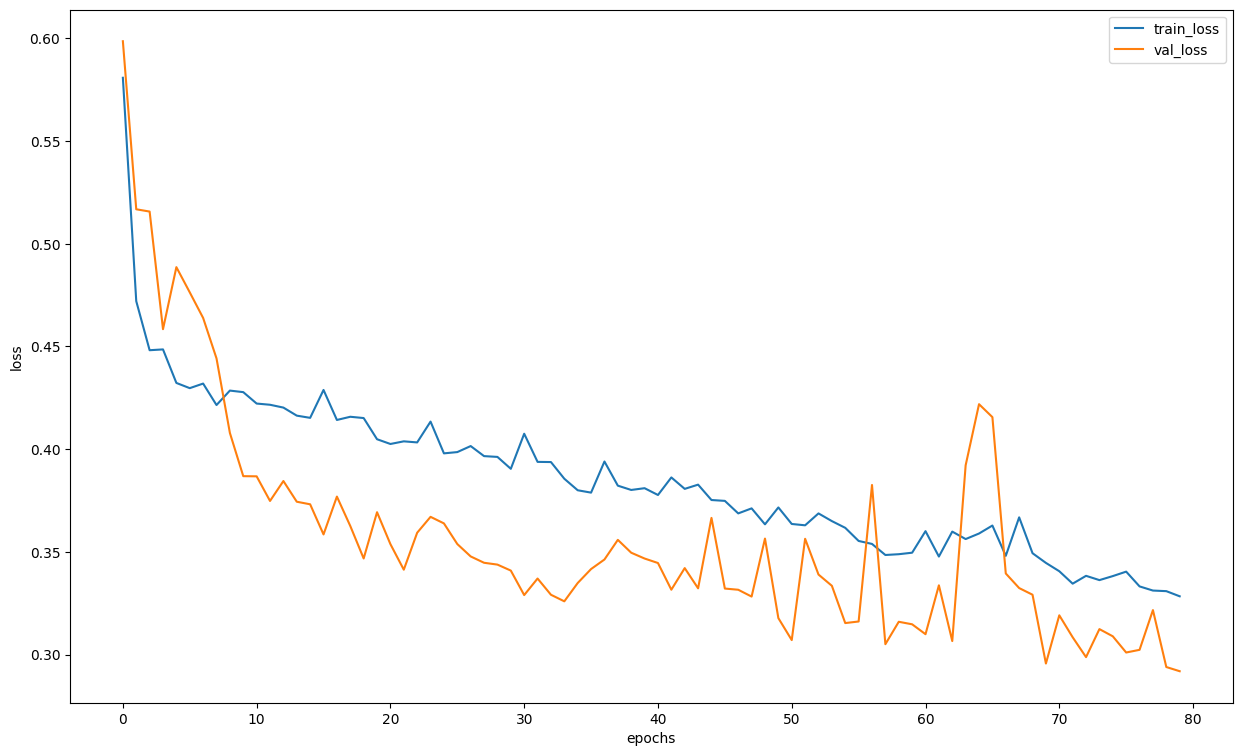

In [34]:
loss_dynamics(result_seg_dice)

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

We have already tried BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

The problem with this loss is that it tends to favor the **majority** (background) class over the **minority** (front) class. Therefore, weights are usually applied to each class:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Traditionally, the weight $\alpha_i$ is defined as the inverse of the frequency of that pixel's class $i$, so that observations of the minority class weigh more relative to the majority class.

Another recent addition is the weighted pixel variant, which weights each pixel by the degree of confidence we have in the prediction of that pixel.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Let's fix $\gamma=2$.

--------------------------------------------------------------------------------


In [20]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    # y_real = y_real.squeeze(1)
    # y_pred = y_pred.squeeze(1)
    y = y_pred.sigmoid()+eps
    loss = -((1-y)**gamma*y_real*y.log()+(1-y_real)*(1-y+eps).log())
  
    return loss.mean()

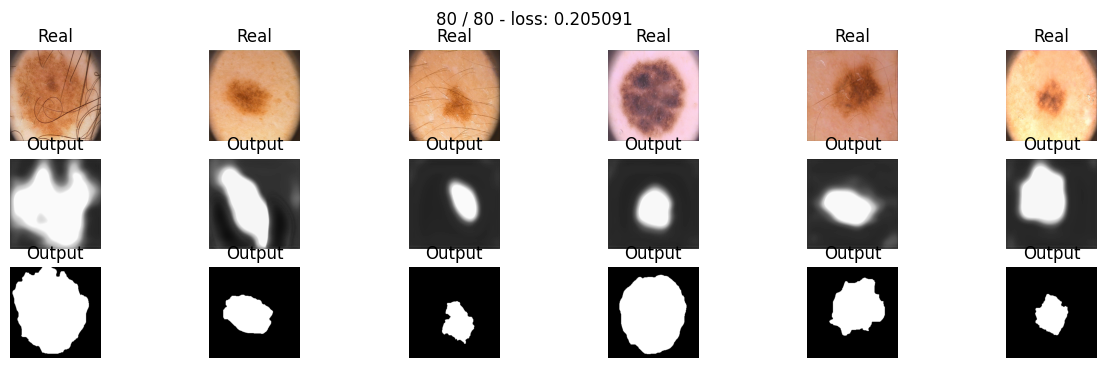

In [21]:
model_focal = SegNet().to(device)

max_epochs = 80
optim = torch.optim.AdamW(model_focal.parameters(), lr=0.001)
results_seg_foc = train(model_focal, optim, focal_loss, max_epochs, data_tr, data_val)

In [22]:
score_seg_foc = score_model(model_focal, iou_pytorch, data_val)

In [23]:
score_seg_foc

0.6199999749660492

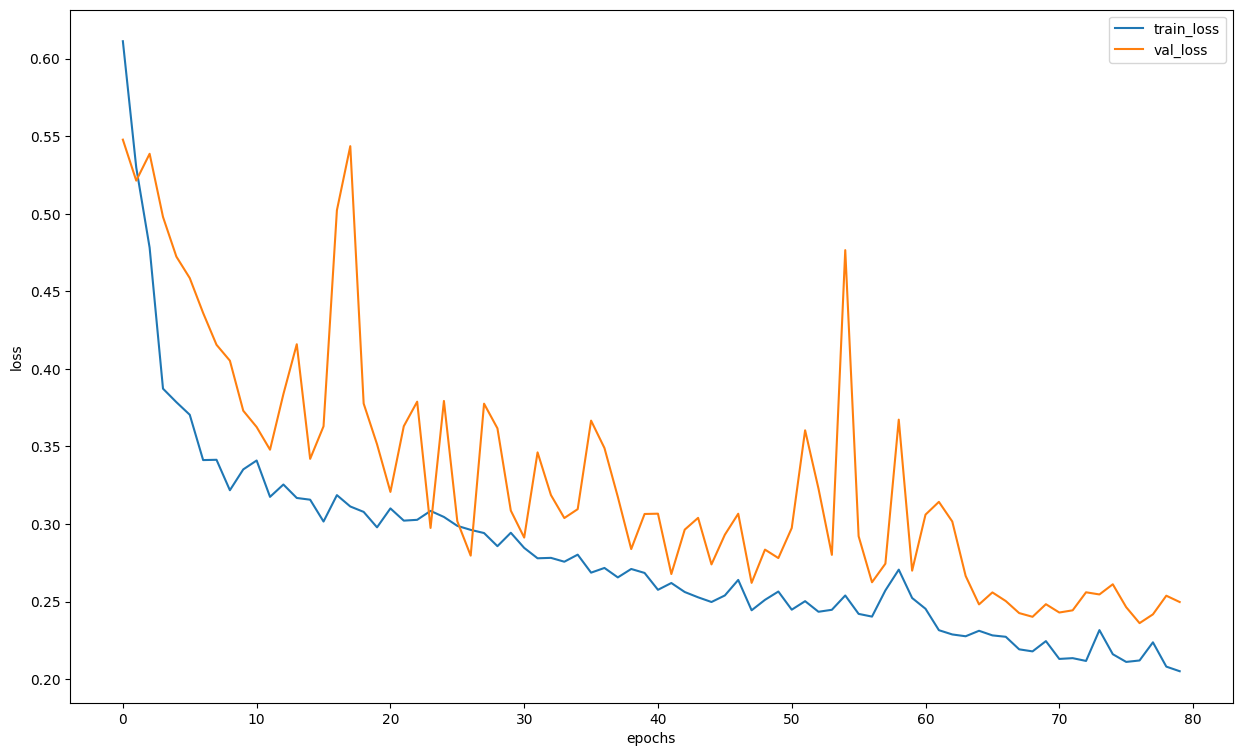

In [26]:
loss_dynamics(results_seg_foc)

----------------------------------------------------------------------------------------------
## World of Segmentation Losses 

Now we will try out the following loss ficntion:

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)


In [19]:
def tversky_loss(y_real, y_pred, smooth=1e-8, alpha=0.3, beta=0.7):
    y_pred = y_pred.sigmoid().view(-1)
    y_real = y_real.view(-1)

    TP = (y_pred * y_real).sum() #True Positive
    FP = ((1-y_real) * y_pred).sum() #False Positive
    FN = (y_real * (1-y_pred)).sum() #False Negative

    return 1 - (TP + smooth) / (TP + alpha*FP + beta*FN + smooth) 

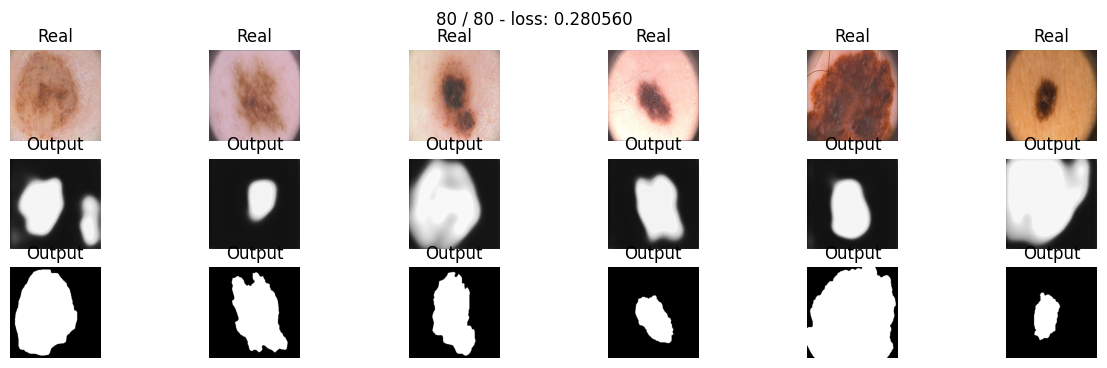

In [22]:
model_tversky = SegNet().to(device)
max_epochs = 80
optimizer = torch.optim.AdamW(model_tversky.parameters(), lr=0.001)
result_seg_tv = train(model_tversky, optimizer, tversky_loss, max_epochs, data_tr, data_val)

In [24]:
score_seg_tv = score_model(model_tversky, iou_pytorch, data_val)

In [25]:
score_seg_tv

0.6719999611377716

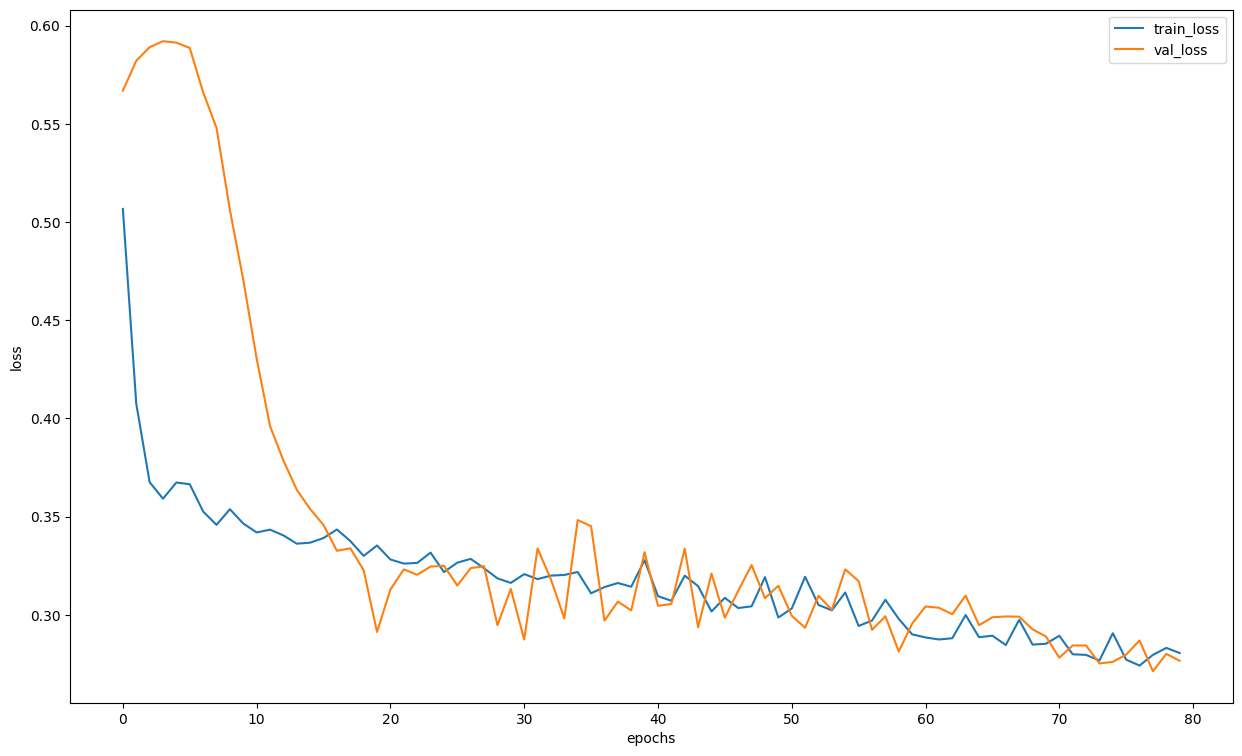

In [26]:
loss_dynamics(result_seg_tv)

-----------------------------------------------------------------------------------------

# U-Net 

[**U-Net**](https://arxiv.org/abs/1505.04597) is a neural network architecture that takes an image and outputs it. It was originally conceived for semantic segmentation (as we will use it), but it is so successful that it has since been used in other contexts. Given a medical image as input, it will output a grayscale image where the intensity of each pixel depends on the probability that that pixel belongs to the region of interest.

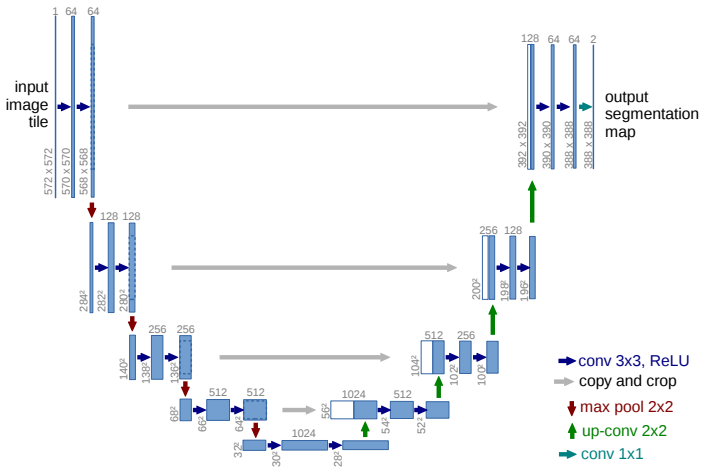

In our architecture we still have encoder and decoder as in **SegNet**, but the distinctive feature of this model is *skip-conenctions* connecting parts of decoder and encoder. That is, in order to pass a tensor to the decoder input, we concatenate the symmetric output from the encoder and the output of the previous decoder layer.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [16]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
          nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(64),
          nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(kernel_size = 2, stride = 2) # 256 -> 128
        self.enc_conv1 = nn.Sequential(
          nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(128),
          nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
          nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(256),
          nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
          nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(512),
          nn.ReLU(),
          nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(512),
          nn.ReLU(),
          nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(512),
          nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn. Sequential(
          nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=1),                       
          nn.BatchNorm2d(1024),
          nn.ReLU(inplace=True),
          nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1),
          nn.BatchNorm2d(512),
          nn.ReLU(inplace=True)
        )

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
          nn.Conv2d(in_channels = 512*2, out_channels = 256, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(256),
          nn.ReLU()
        )
        self.upsample1 = nn.Upsample(scale_factor=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
          nn.Conv2d(in_channels = 256*2, out_channels = 128, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(128),
          nn.ReLU()
        )
        self.upsample2 = nn.Upsample(scale_factor=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
          nn.Conv2d(in_channels = 128*2, out_channels = 64, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(64),
          nn.ReLU()
        )
        self.upsample3 = nn.Upsample(scale_factor=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
          nn.Conv2d(in_channels = 64*2, out_channels = 1, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(1),
          nn.ReLU(),
          nn.Conv2d(in_channels = 1, out_channels = 1, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(1),
          #nn.ReLU()
                                                                                              
        )

    def forward(self, x):
        # encoder
        e00 = self.enc_conv0(x)
        e0 = self.pool0(e00)
        e11 = self.enc_conv1(e0)
        e1 = self.pool1(e11)
        e22 = self.enc_conv2(e1)
        e2 = self.pool2(e22)
        e33 = self.enc_conv3(e2)
        e3 = self.pool3(e33)

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(torch.cat([self.upsample0(b),e33],1))
        d1 = self.dec_conv1(torch.cat([self.upsample1(d0),e22],1))
        d2 = self.dec_conv2(torch.cat([self.upsample2(d1),e11],1))
        d3 = self.dec_conv3(torch.cat([self.upsample3(d2),e00],1)) # no activation
        return d3

In [38]:
clear_gpu_memory()

In [17]:
unet_model = UNet().to(device)

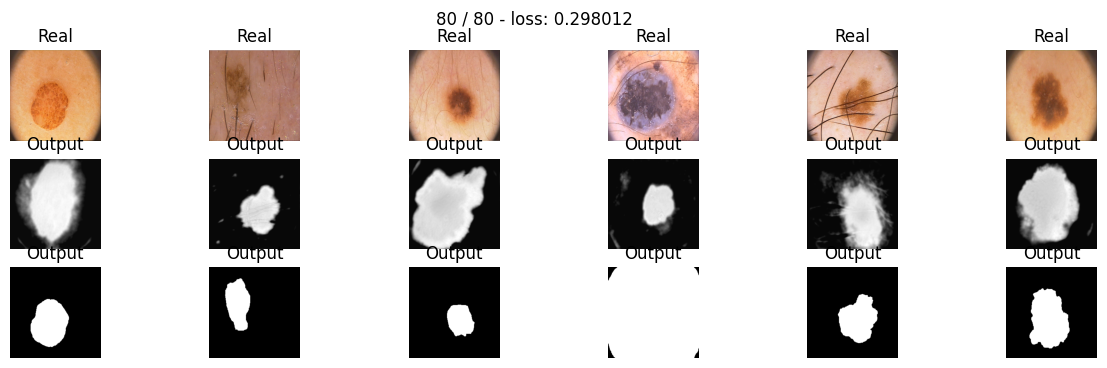

In [18]:
max_epochs = 80
optimizer = torch.optim.AdamW(unet_model.parameters(), lr=0.001)
result_u_bce = train(unet_model, optimizer, bce_loss, max_epochs, data_tr, data_val)

In [19]:
score_u_bce = score_model(unet_model, iou_pytorch, data_val)

In [20]:
score_u_bce

0.6939999759197235

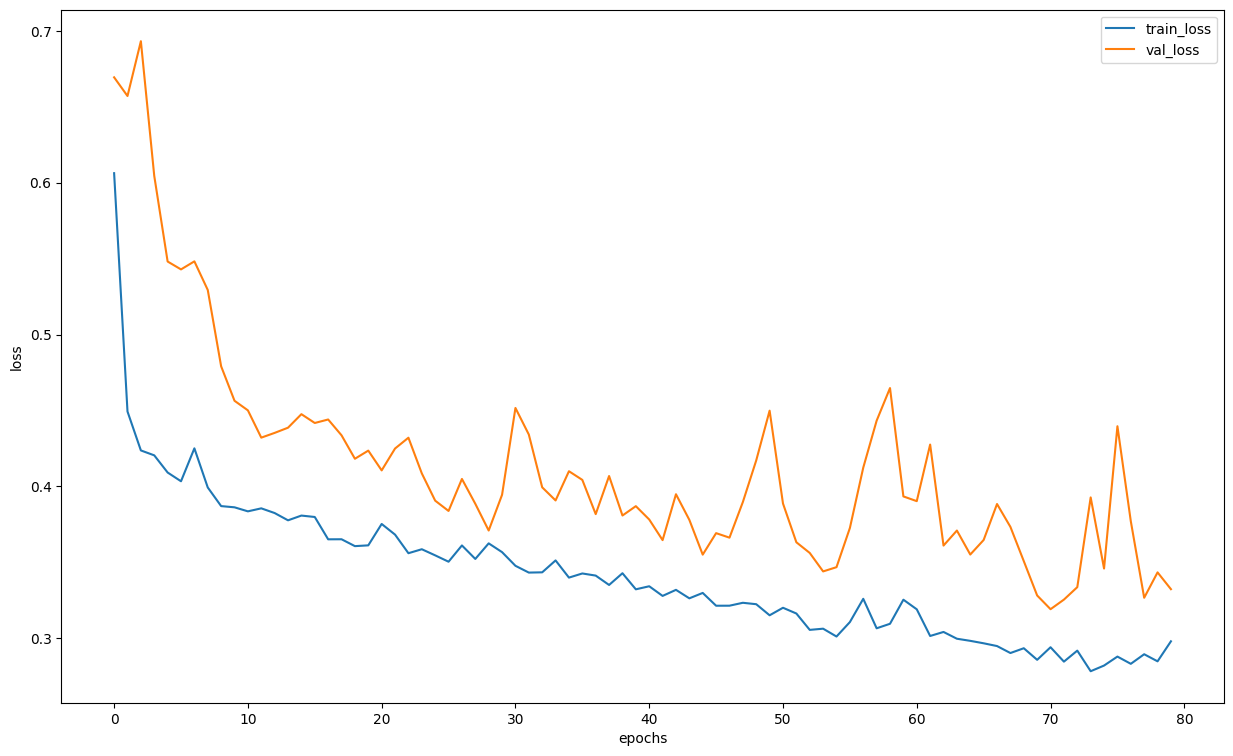

In [21]:
loss_dynamics(result_u_bce)

New model by changing the pooling type:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)




In [22]:
clear_gpu_memory()

In [23]:
class UNet2(nn.Module):
     def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
          nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(64),
          nn.ReLU()
        )
        self.pool0 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1) # 256 -> 128
        self.enc_conv1 = nn.Sequential(
          nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(128),
          nn.ReLU()
        )
        self.pool1 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
          nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(256),
          nn.ReLU()
        )
        self.pool2 = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
          nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(512),
          nn.ReLU(),
          nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(512),
          nn.ReLU(),
          nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(512),
          nn.ReLU()
        )
        self.pool3 = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn. Sequential(
          nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=1),                       
          nn.BatchNorm2d(1024),
          nn.ReLU(inplace=True),
          nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1),
          nn.BatchNorm2d(512),
          nn.ReLU(inplace=True)
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
          nn.Conv2d(in_channels = 512*2, out_channels = 256, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(256),
          nn.ReLU()
        )
        self.upsample1 = nn.ConvTranspose2d(256, 256, kernel_size=3, stride=2, padding=1) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
          nn.Conv2d(in_channels = 256*2, out_channels = 128, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(128),
          nn.ReLU()
        )
        self.upsample2 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
          nn.Conv2d(in_channels = 128*2, out_channels = 64, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(64),
          nn.ReLU()
        )
        self.upsample3 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
          nn.Conv2d(in_channels = 64*2, out_channels = 1, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(1),
          nn.ReLU(),
          nn.Conv2d(in_channels = 1, out_channels = 1, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(1),
          #nn.ReLU()
                                                                                              
        )

     def forward(self, x):
        # encoder
        e00 = self.enc_conv0(x)
        e0 = self.pool0(e00)
        e11 = self.enc_conv1(e0)
        e1 = self.pool1(e11)
        e22 = self.enc_conv2(e1)
        e2 = self.pool2(e22)
        e33 = self.enc_conv3(e2)
        e3 = self.pool3(e33)

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(torch.cat([self.upsample0(b, output_size=e33.size()),e33],1))
        d1 = self.dec_conv1(torch.cat([self.upsample1(d0, output_size=e22.size()),e22],1))
        d2 = self.dec_conv2(torch.cat([self.upsample2(d1, output_size=e11.size()),e11],1))
        d3 = self.dec_conv3(torch.cat([self.upsample3(d2, output_size=e00.size()),e00],1)) # no activation
        return d3 


In [24]:
unet2_model = UNet2().to(device)


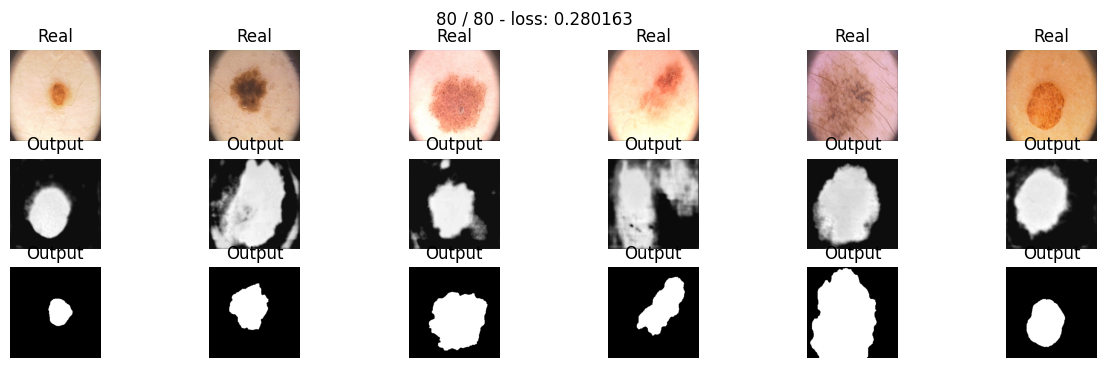

In [25]:
max_epochs = 80
optimizer = torch.optim.AdamW(unet2_model.parameters(), lr=0.001)
result_u2_bce = train(unet2_model, optimizer, bce_loss, max_epochs, data_tr, data_val)

In [26]:
score_u2_bce = score_model(unet_model, iou_pytorch, data_val)

In [28]:
score_u2_bce

0.6940000057220459

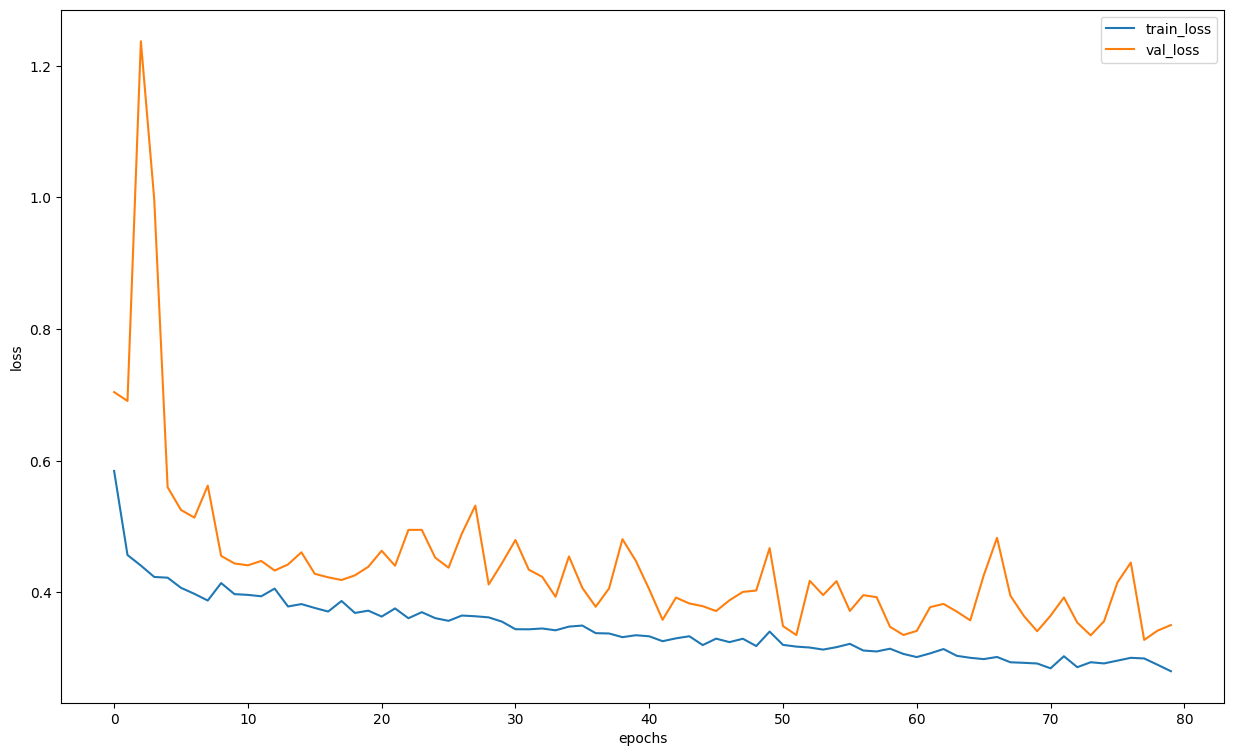

In [27]:
loss_dynamics(result_u2_bce)

**Conclusions**.

If we compare the models by the final value of the metric on the validation sample, we can draw the following conclusion. For SegNet, the best scoring was obtained on dice loss.


Seg bce score 0.658

Seg dice score 0.676

Seg foc score 0.620

Seg tversky score 0.6720

Let's take a closer look at the different loss functions for SegNet. The BCE loss decreasing graph is the most gentle, but it has the most stable dynamics.
Focal and Tversky have frequent large fluctuations, though at the initial epochs they fall sharply into small loss. Dice is more stable, though also prone to oscillations.

For further analysis I choose BCE loss, as it is the most popular for such tasks and behaves more predictably. U-Net 1/2 showed the best results in this experiment - it gave a score of 0.694 with a rather stable graph of the loss function. Probably, the number of epochs for Unet 1/2 can be greatly increased, unlike SegNet